## Implementation of GoogLeNet

We will use the [tensorflow.keras Functional API](https://www.tensorflow.org/guide/keras/functional) to build GoogLeNet from the original paper: “[Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)” by Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.

[Video tutorial](https://www.youtube.com/watch?v=fq2srEX7VV0&list=PLaPdEEY26UXyE3UchW0C742xh542yh0yI&index=3)

---

In the paper we can read:

>**[i]** “All the convolutions, including those inside the Inception modules, use rectified linear activation”

<br>

We will also use the following Table **[ii]**:

<img src=https://raw.githubusercontent.com/Machine-Learning-Tokyo/DL-workshop-series/master/Part%20I%20-%20Convolution%20Operations/images/GoogleNet/GoogleNet.png width="700">

<br>

as well the following Diagram **[iii]** of the Inception block:

<img src=https://raw.githubusercontent.com/Machine-Learning-Tokyo/DL-workshop-series/master/Part%20I%20-%20Convolution%20Operations/images/GoogleNet/Inception_block.png width="300">

---

## Network architecture

In GoogleNet starts with two Conv-MaxPool blocks and then continues with a series of **Inception** blocks separated by *Max Pool* layers before the fineal *Fully Connected* layer.

### Inception block

The Inception block is depicted at **[iii]**.

It takes as input a tensor and passes it through **4 different streams**:
1. a 1x1 Conv layer
2. a 1x1 Conv layer followed by a 3x3 Conv layer
3. a 1x1 Conv layer followed by a 5x5 Conv layer
4. a 3x3 Max Pool layer followed by a 1x1 Conv layer

The output tensors of all four final Conv layers are **concatenated** to one tensor.

---

## Workflow
We will:
1. import the neccesary layers
2. write a helper function for the inception_block()
3. test inception_block()
4. write the code for the stem of the model
5. write the code for the main part (Inception blocks) of the model

---

### 1. Imports

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,Concatenate, AvgPool2D, Dropout, Flatten, Dense

### 2. inception_block()
Next, we will build the *Inception block* as a function that will:
- take as inputs:
  - a tensor (**`x`**)
  - a list with the number of filters for each one of the 6 Convolutional layers of an Inception block (**`filters`**)
- run:
    - apply the structure of *Inception block* as described above
- return the tensor

and will return the concatenaded tensor **`output`**.

In [2]:
def inception_block(x, filters):
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    t4 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t4 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t4)

    output = Concatenate()([t1, t2, t3, t4])
    return output


### 3. Stem of the model
#### Part 1

From the *Table*:


| type        	|  patch size / stride 	| output size |
|-------------	|:--------------------:	|:-----------:|
| convolution 	|        7x7 / 2       	| 112x112x64  |
| max pool    	|        3x3 / 2       	| 56x56x64    

In [3]:
input = Input(shape=(224, 224, 3))
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

#### Part 2

From the *Table*:


| type        	|  patch size / stride 	| #3x3 reduce 	| #3x3 	|
|-------------	|:--------------------:	|:-----------:	|:----:	|
| convolution 	|        3x3 / 1       	| 64          	| 192  	|
| max pool    	|        3x3 / 2       	|             	|      	|


In [4]:
x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

### 4. Main part of the model

#### Part 3
From the *Table*:


| type          	|  patch size / stride 	| #1x1 	| #3x3 reduce 	| #3x3 	| #5x5 reduce 	| #5x5 	| pool proj 	|
|---------------	|:--------------------:	|:----:	|:-----------:	|:----:	|:-----------:	|:----:	|:---------:	|
| inception(3a) 	|                      	| 64   	| 96          	| 128  	| 16          	| 32   	| 32        	|
| inception(3b) 	|                      	| 128  	| 128         	| 192  	| 32          	| 96   	| 64        	|
| max pool      	|        3x3 / 2       	|      	|             	|      	|             	|      	|           	|


In [5]:
x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

#### Part 4
From the *Table*:


| type          	|  patch size / stride 	| #1x1 	| #3x3 reduce 	| #3x3 	| #5x5 reduce 	| #5x5 	| pool proj 	|
|---------------	|:--------------------:	|:----:	|:-----------:	|:----:	|:-----------:	|:----:	|:---------:	|
| inception(4a) 	|                      	| 192  	| 96          	| 208  	| 16          	| 48   	| 64        	|
| inception(4b) 	|                      	| 160  	| 112         	| 224  	| 24          	| 64   	| 64        	|
| inception(4c) 	|                      	| 128  	| 128         	| 256  	| 24          	| 64   	| 64        	|
| inception(4d) 	|                      	| 112  	| 144         	| 288  	| 32          	| 64   	| 64        	|
| inception(4e) 	|                      	| 256  	| 160         	| 320  	| 32          	| 128  	| 128       	|
| max pool      	|        3x3 / 2       	|      	|             	|      	|             	|      	|           	|


In [6]:
x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

#### Part 5
From the *Table*:


| type          	|  patch size / stride 	| #1x1 	| #3x3 reduce 	| #3x3 	| #5x5 reduce 	| #5x5 	| pool proj 	|
|---------------	|:--------------------:	|:----:	|:-----------:	|:----:	|:-----------:	|:----:	|:---------:	|
| inception(5a) 	|                      	| 256  	| 160         	| 320  	| 32          	| 128  	| 128       	|
| inception(5b) 	|                      	| 384  	| 192         	| 384  	| 48          	| 128  	| 128       	|
| avg pool      	|        7x7 / 1       	|      	|             	|      	|             	|      	|           	|
| dropout(40%)  	|                      	|      	|             	|      	|             	|      	|           	|
| linear        	|                      	|      	|             	|      	|             	|      	|           	|
| softmax       	|                      	|      	|             	|      	|             	|      	|           	|


In [7]:
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
x = AvgPool2D(pool_size=7, strides=1)(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)
output = Dense(units=1000, activation='softmax')(x)

### Model definition

In [8]:
from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)

## Final code

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, \
     Concatenate, AvgPool2D, Dropout, Flatten, Dense
      
def inception_block(x, filters):
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    t4 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t4 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t4)

    output = Concatenate()([t1, t2, t3, t4])
    return output


input = Input(shape=(224, 224, 3))
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
x = AvgPool2D(pool_size=7, strides=1)(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)
output = Dense(units=1000, activation='softmax')(x)

from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_114[0][0]']             
 )                                                                                          

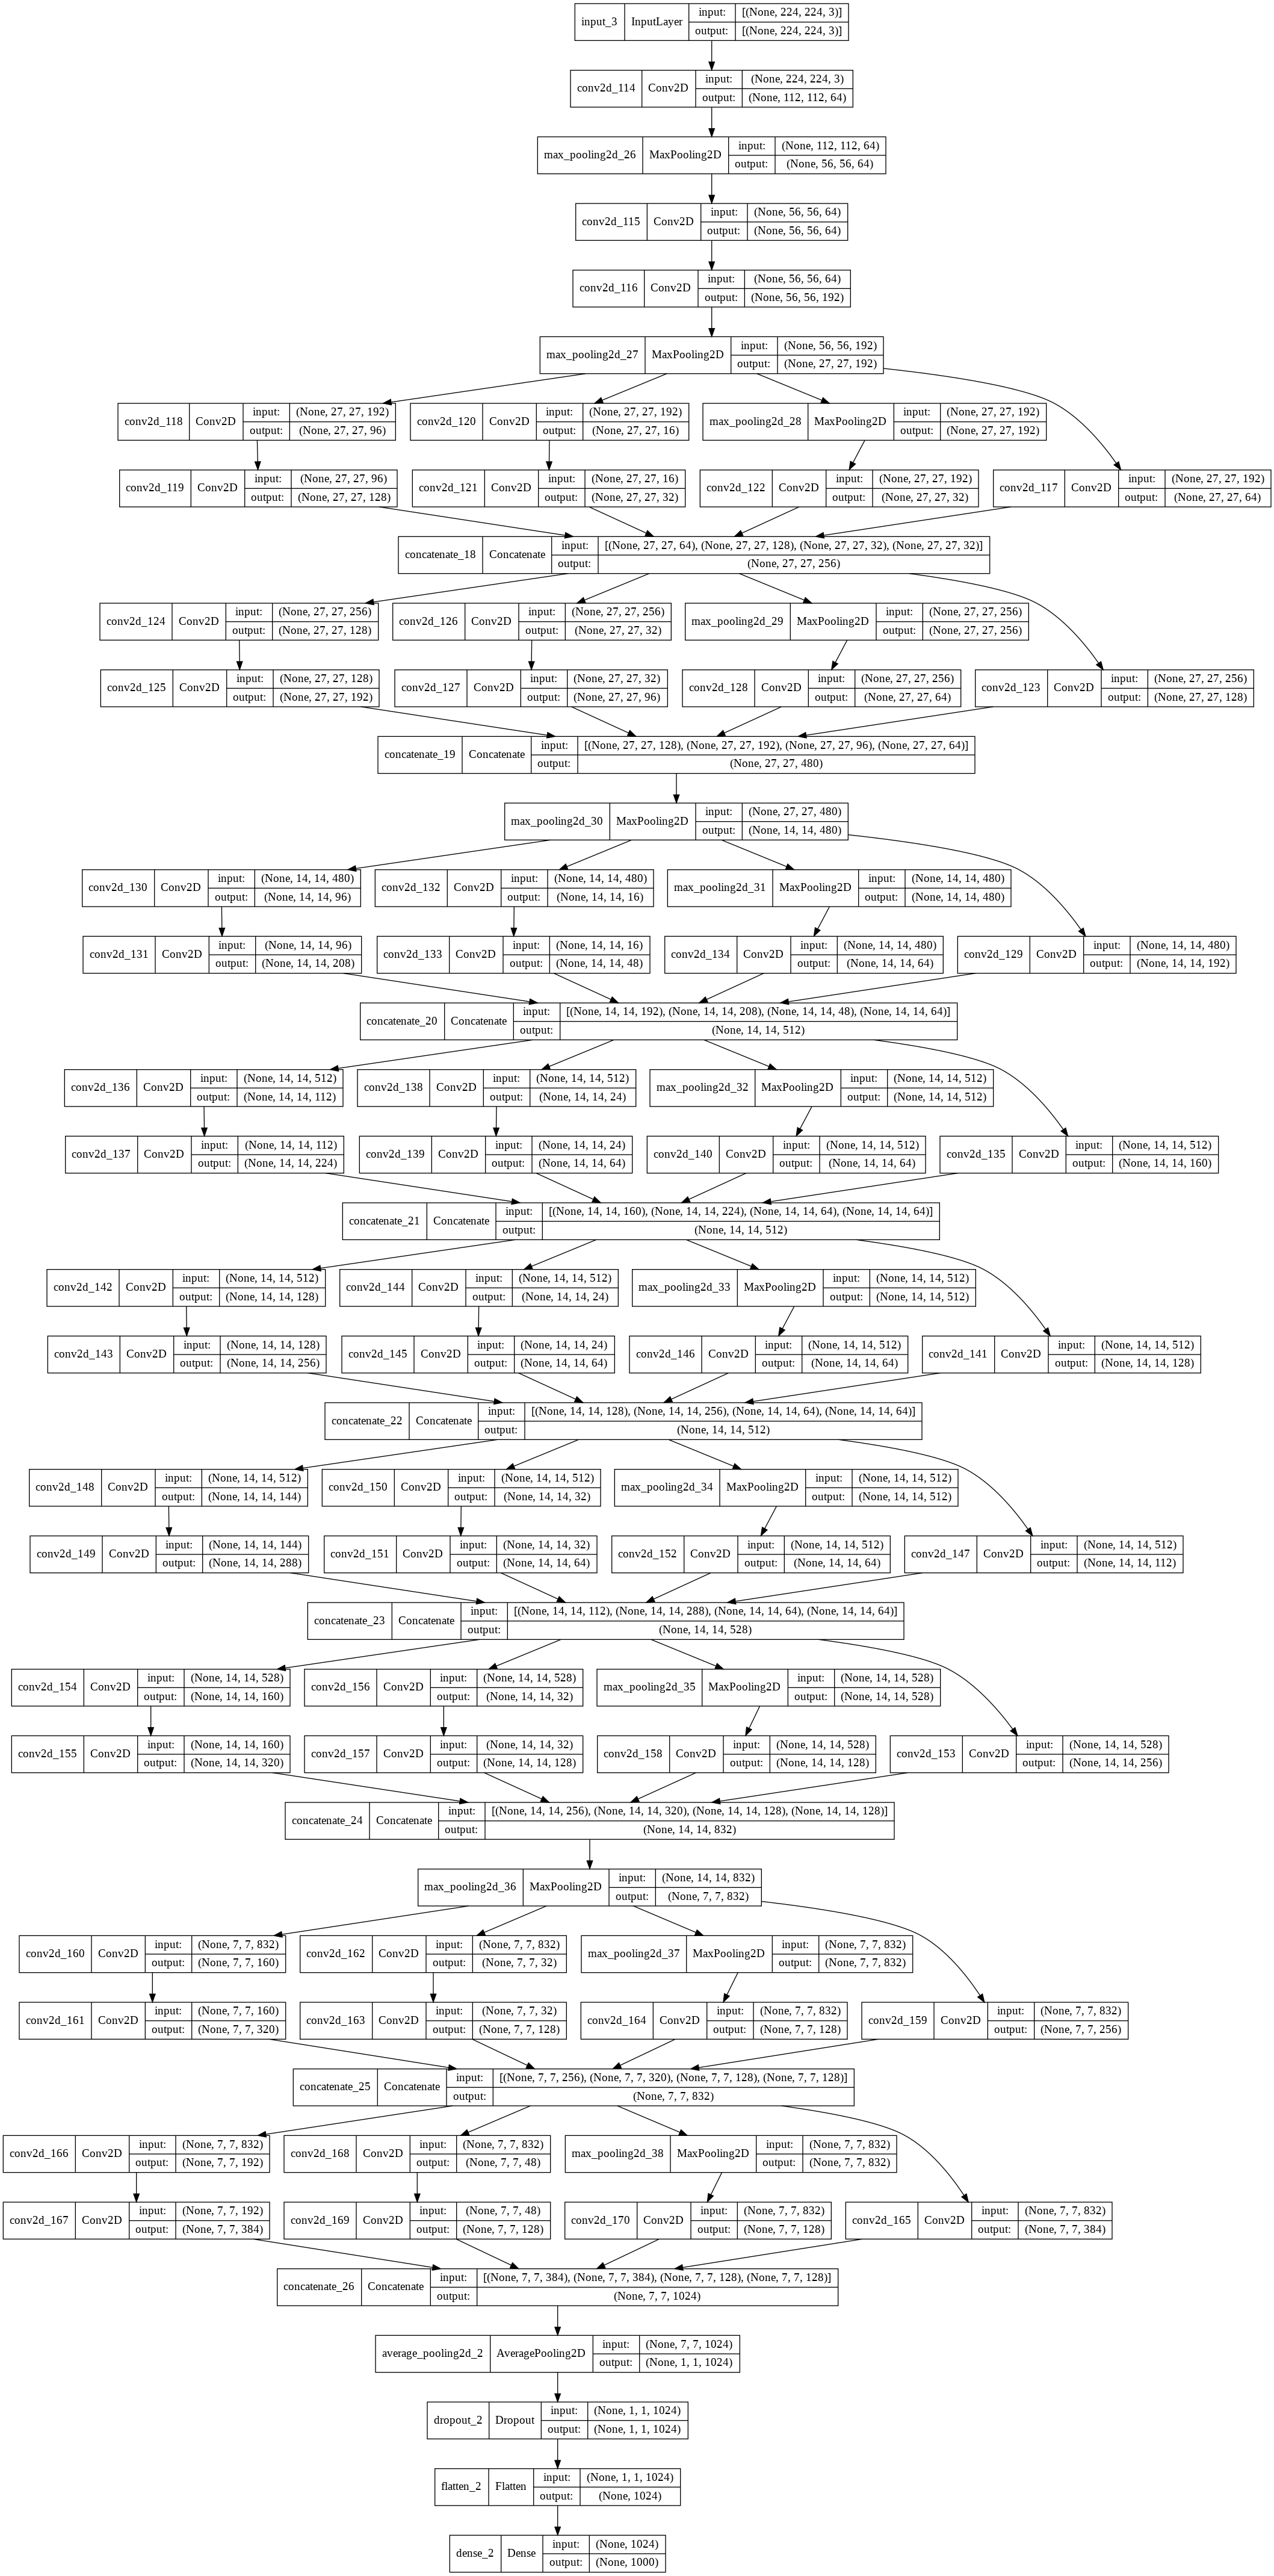

In [11]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)